# Model evaluation 
Part 1


### Environment Setup
To run this notebook, you need to have the following Python libraries installed:

- `pandas`
- `numpy`
- `scikit-learn`
- `matplotlib`
- `pickle`

You can install them with `pip`:

```bash
pip install pandas numpy scikit-learn matplotlib
```

Or you can set up conda environment and install all the needed libraries using the following command:
```bash 
conda env create -f environment.yml
conda activate model_evaluation
```

In [2]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from itertools import product
import matplotlib.pyplot as plt
import pickle

In [3]:
file_path = 'data/dataset.csv'
df = pd.read_csv(file_path, sep=';', header=0)

df.head()

,ShotType,Competition,PlayerType,Transition,TwoLegged,Movement,Angle,Distance
0,above head,U14,F,1,1,no,73.83,0.73
1,layup,U14,F,0,1,no,28.13,1.02
2,above head,U14,F,0,1,no,51.88,7.22
3,above head,U14,F,1,1,no,80.84,3.64
4,above head,U14,F,0,1,no,30.89,7.20


In [4]:
categorical_columns = df.select_dtypes(include=['object']).columns
unique_classes = df[categorical_columns].nunique()
print("Number of unique classes in each categorical column:")
print(unique_classes)

Number of unique classes in each categorical column:
ShotType       6
Competition    5
PlayerType     3
Movement       3
dtype: int64


In [5]:
categorical_columns = ["Competition", "PlayerType", "Movement"]
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [6]:
y = df_encoded['ShotType']
X = df_encoded.drop(columns=['ShotType'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Helper functions

In [7]:
def log_loss(y_true, y_pred):
    """
    Compute the log loss (logarithmic loss) for multiclass classification.

    Parameters:
    - y_true: True labels (integers representing classes).
    - y_pred: Predicted probabilities for each class (2D array).

    Returns:
    - log_loss: The computed log loss.
    """
    # clip predicted probabilities to avoid log(0) or log(1)
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    
    # convert y_true to one-hot encoding
    y_true_one_hot = np.eye(y_pred.shape[1])[y_true]
    
    loss = -np.mean(np.sum(y_true_one_hot * np.log(y_pred), axis=1))
    
    return loss

In [8]:
def accuracy_score(y_true, y_pred):
    """
    Compute the accuracy score for classification.

    Parameters:
    - y_true: True labels.
    - y_pred: Predicted labels.

    Returns:
    - accuracy: The computed accuracy score.
    """
    correct = np.sum(y_true == y_pred)
    
    accuracy = correct / len(y_true)
    
    return accuracy

In [9]:
def flat_cv(model_arg, X, y, param_grid=None, n_splits=5):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    if param_grid is None:
        param_grid = [{}]  
    
    best_params = None
    log_loss_min_avg = float('inf')
    acc_max = 0.0
    best_acc_se = 0.0
    best_log_loss_se = 0.0
    
    for params in param_grid:
        acc_scores = []
        log_loss_scores = []
        
        for train_idx, test_idx in cv.split(X):
            X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
            y_train_cv, y_test_cv = y[train_idx], y[test_idx]
            
            model = model_arg(**params, random_state=42)
            model.fit(X_train_cv, y_train_cv)
            
            y_pred_proba = model.predict_proba(X_test_cv)
            y_pred = model.predict(X_test_cv)
            
            acc_scores.append(accuracy_score(y_test_cv, y_pred))
            log_loss_scores.append(log_loss(y_test_cv, y_pred_proba))
        
        acc_avg = np.mean(acc_scores)
        log_loss_avg = np.mean(log_loss_scores)
        
        acc_se = np.sqrt((acc_avg * (1 - acc_avg)) / n_splits)
        log_loss_std = np.std(log_loss_scores, ddof=1)  
        log_loss_se = log_loss_std / np.sqrt(n_splits)
        
        # Best model check based on log loss
        if log_loss_avg < log_loss_min_avg:
            log_loss_min_avg = log_loss_avg
            acc_max = acc_avg
            best_params = params
            best_acc_se = acc_se
            best_log_loss_se = log_loss_se
    
    return acc_max, log_loss_min_avg, best_params, best_acc_se, best_log_loss_se


## Comparison of Three Machine Learning Models

In [10]:
# converting the output string labels to integers 
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

### 1. Baseline model
Learns and Predicts the Relative Frequencies of Classes

In [13]:
baseline_acc, baseline_log_loss_min, best_hyperparams, baseline_best_acc_se, baseline_best_log_loss_se = flat_cv(DummyClassifier, X_train, y_train_encoded, [{"strategy": "prior"}])
print(f"Accuracy approximation: {baseline_acc:.4f} ± {baseline_best_acc_se:.4f}")
print(f"Log Loss approximation: {baseline_log_loss_min:.4f} ± {baseline_best_log_loss_se:.4f}")

final_model = DummyClassifier(strategy="prior")
final_model.fit(X_train, y_train_encoded)

y_pred_baseline = final_model.predict(X_test)
y_pred_proba_baseline = final_model.predict_proba(X_test)
baseline_accuracy = accuracy_score(y_test_encoded, y_pred_baseline)
baseline_log_score = log_loss(y_test_encoded, y_pred_proba_baseline)

print(f"Test Accuracy: {baseline_accuracy:.4f}")
print(f"Test Log Loss: {baseline_log_score:.4f}")

Accuracy approximation: 0.6115 ± 0.2180
Log Loss approximation: 1.1656 ± 0.0102
Test Accuracy: 0.6001
Test Log Loss: 1.1684


### 2. Logistic Regression

In [14]:
log_reg_acc, log_reg_log_loss_min, log_reg_best_hyperparams, log_reg_best_acc_se, log_reg_best_log_loss_se = flat_cv(LogisticRegression, X_train, y_train_encoded, [{"max_iter": 1500}])
print(f"Accuracy approximation: {log_reg_acc:.4f} ± {log_reg_best_acc_se:.4f}")
print(f"Log Loss approximation: {log_reg_log_loss_min:.4f} ± {log_reg_best_log_loss_se:.4f}")

final_log_reg = LogisticRegression(max_iter=1500)
final_log_reg.fit(X_train, y_train_encoded)

y_pred_lr = final_log_reg.predict(X_test)
y_pred_proba_lr = final_log_reg.predict_proba(X_test)
lr_accuracy = accuracy_score(y_test_encoded, y_pred_lr)
lr_log_score = log_loss(y_test_encoded, y_pred_proba_lr)

print(f"Test Accuracy: {lr_accuracy:.4f}")
print(f"Test Log Loss: {lr_log_score:.4f}")

Accuracy approximation: 0.7329 ± 0.1979
Log Loss approximation: 0.6888 ± 0.0076
Test Accuracy: 0.7427
Test Log Loss: 0.6514


### 3. Random Forest

In [15]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# to generate all combinations of hyperparameters
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]


#### Approach 1: Optimizing training fold performance

In [16]:
rf1_best_accuracy, rf1_log_loss_min_avg, rf1_best_hyperparams, rf1_best_acc_se, rf1_best_log_loss_se = flat_cv(RandomForestClassifier, X_train, y_train_encoded, param_combinations)
print(f"Best Hyperparameters: {rf1_best_hyperparams}")
print(f"Accuracy approximation: {rf1_best_accuracy:.4f} ± {rf1_best_acc_se:.4f}")
print(f"Log Loss approximation: {rf1_log_loss_min_avg:.4f} ± {rf1_best_log_loss_se:.4f}")

final_model = RandomForestClassifier(**rf1_best_hyperparams)
final_model.fit(X_train, y_train_encoded)

y_pred_rf1 = final_model.predict(X_test)
y_pred_proba_rf1 = final_model.predict_proba(X_test)
rf1_test_accuracy = accuracy_score(y_test_encoded, y_pred_rf1)
rf1_test_log_loss = log_loss(y_test_encoded, y_pred_proba_rf1)

print(f"Test Accuracy: {rf1_test_accuracy:.4f}")
print(f"Test Log Loss: {rf1_test_log_loss:.4f}")

Best Hyperparameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}
Accuracy approximation: 0.7531 ± 0.1928
Log Loss approximation: 0.6413 ± 0.0079
Test Accuracy: 0.7732
Test Log Loss: 0.6032


#### Approach 2: Nested cross-validation

In [17]:
def nested_cv(X, y, param_grid, outer_splits=5, inner_splits=5):
    cv_outer = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
    
    acc_scores = []
    log_loss_scores = []
    best_params_final = None  
    best_log_loss_final = float('inf') 
    
    outer_fold = 0
    for tr_outer_idx, te_outer_idx in cv_outer.split(X):
        outer_fold += 1
        print(f"Outer fold {outer_fold}/{outer_splits}")
        
        X_tr_outer, X_te_outer = X.iloc[tr_outer_idx], X.iloc[te_outer_idx]
        y_tr_outer, y_te_outer = y[tr_outer_idx], y[te_outer_idx]
        
        log_loss_min = float('inf')
        best_params = None 
        
        # Inner cross-validation for hyperparameter tuning
        cv_inner = KFold(n_splits=inner_splits, shuffle=True, random_state=42)
        
        for params in param_grid:
            log_loss_total = []
            acc_total = []
            
            for tr_inner_idx, te_inner_idx in cv_inner.split(X_tr_outer):
                X_tr_inner, X_te_inner = X_tr_outer.iloc[tr_inner_idx], X_tr_outer.iloc[te_inner_idx]
                y_tr_inner, y_te_inner = y_tr_outer[tr_inner_idx], y_tr_outer[te_inner_idx]
                
                model = RandomForestClassifier(**params, random_state=42)
                model.fit(X_tr_inner, y_tr_inner)
                
                y_pred_proba = model.predict_proba(X_te_inner)
                y_pred = model.predict(X_te_inner)
                
                acc_total.append(accuracy_score(y_te_inner, y_pred))
                log_loss_total.append(log_loss(y_te_inner, y_pred_proba))
            
            acc_avg = np.mean(acc_total)
            log_loss_avg = np.mean(log_loss_total)
            
            # Select best parameters based on log loss
            if log_loss_avg < log_loss_min:
                log_loss_min = log_loss_avg
                best_params = params
        
        # Track the best parameters across all outer folds based on log loss
        if log_loss_min < best_log_loss_final:
            best_log_loss_final = log_loss_min
            best_params_final = best_params
        
        # Train the best model on the full outer training set
        best_model = RandomForestClassifier(**best_params, random_state=42)
        best_model.fit(X_tr_outer, y_tr_outer)
        
        # Evaluate on the outer test set
        y_pred_proba = best_model.predict_proba(X_te_outer)
        y_pred = best_model.predict(X_te_outer)
        
        acc_scores.append(accuracy_score(y_te_outer, y_pred))
        log_loss_scores.append(log_loss(y_te_outer, y_pred_proba))
    
    # Compute final accuracy and log loss mean
    acc_final_avg = np.mean(acc_scores)
    log_loss_final_avg = np.mean(log_loss_scores)
    
    # Compute standard deviation and log-loss
    best_log_loss_std = np.std(log_loss_scores, ddof=1)
    
    # Compute standard error for accuracy (based on n_test)
    acc_se = np.sqrt((acc_final_avg * (1 - acc_final_avg)) / outer_splits)
    
    # Compute standard error for log-loss (based on the number of outer folds)
    log_loss_se = best_log_loss_std / np.sqrt(outer_splits)
    
    return acc_final_avg, log_loss_final_avg, best_params_final, acc_se, log_loss_se


In [18]:
best_accuracy2, best_log_loss2, best_hyperparams2, best_acc_std2, best_log_loss_std2 = nested_cv(X_train, y_train_encoded, param_combinations)
print("-----------------------------------------------")
print("Nested Cross-Validation Results")
print(f"Best Hyperparameters: {best_hyperparams2}")
print(f"Accuracy approximation: {best_accuracy2:.4f} ± {best_acc_std2:.4f}")
print(f"Log Loss approximation: {best_log_loss2:.4f} ± {best_log_loss_std2:.4f}")

rf2 = RandomForestClassifier(**best_hyperparams2)
rf2.fit(X_train, y_train_encoded)

y_pred_rf2 = rf2.predict(X_test)
y_pred_proba_rf2 = rf2.predict_proba(X_test)
rf2_test_accuracy = accuracy_score(y_test_encoded, y_pred_rf2)
rf2_test_log_loss = log_loss(y_test_encoded, y_pred_proba_rf2)

print(f"Test Accuracy: {rf2_test_accuracy:.4f}")
print(f"Test Log Loss: {rf2_test_log_loss:.4f}")

Outer fold 1/5
Outer fold 2/5
Outer fold 3/5
Outer fold 4/5
Outer fold 5/5
-----------------------------------------------
Nested Cross-Validation Results
Best Hyperparameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2}
Accuracy approximation: 0.7540 ± 0.1926
Log Loss approximation: 0.6424 ± 0.0089
Test Accuracy: 0.7752
Test Log Loss: 0.6010


## Analysis of results

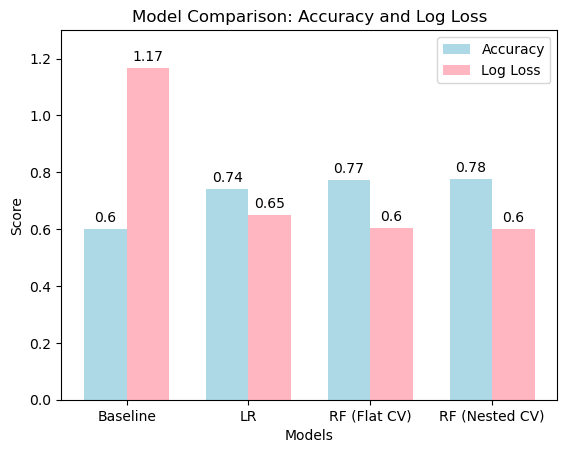

In [21]:
models = ['Baseline', 'LR', 'RF (Flat CV)', 'RF (Nested CV)']
accuracy = [baseline_accuracy, lr_accuracy, rf1_test_accuracy, rf2_test_accuracy]
log_loss = [min(score, 2.5) for score in [baseline_log_score, lr_log_score, rf1_test_log_loss, rf2_test_log_loss]]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='lightblue')
rects2 = ax.bar(x + width/2, log_loss, width, label='Log Loss', color='lightpink')

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Accuracy and Log Loss')
ax.set_xticks(x)
ax.set_xticklabels(models, ha='center')
ax.legend()

ax.set_ylim(0, 1.3)

def autolabel(rects, original_values):
    for rect, original_value in zip(rects, original_values):
        height = rect.get_height()
        label = '2.5+' if original_value > 2 else f'{round(height, 2)}'
        ax.annotate(label,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, accuracy)
autolabel(rects2, [baseline_log_score, lr_log_score, rf1_test_log_loss, rf2_test_log_loss])

plt.savefig('visualizations/model_comparison.png')

plt.show()

In [22]:
data_to_save = {
    'y_true': y_test_encoded,  
    'y_pred_baseline': y_pred_baseline,  # (baseline) model predictions
    'y_pred_proba_baseline': y_pred_proba_baseline,  # (baseline) model probabilities
    'errors_baseline': (y_pred_baseline != y_test_encoded).astype(int),  # (baseline) model errors
    'y_pred_lr': y_pred_lr, 
    'y_pred_proba_lr': y_pred_proba_lr, 
    'errors_lr': (y_pred_lr != y_test_encoded).astype(int),  
    'y_pred_rf1': y_pred_rf1,  
    'y_pred_proba_rf1': y_pred_proba_rf1,
    'errors_rf1': (y_pred_rf1 != y_test_encoded).astype(int), 
    'y_pred_rf2': y_pred_rf2, 
    'y_pred_proba_rf2': y_pred_proba_rf2,  
    'errors_rf2': (y_pred_rf2 != y_test_encoded).astype(int),
    'test_indices': X_test.index
}

with open('all_model_results.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("All model results saved to 'all_model_results.pkl'.")

All model results saved to 'all_model_results.pkl'.
